## Dublin AirBnb  -  Data analysis project 

Data: 
•	Csv file: ‘lisitngs.csv’. A web-scraped csv file from the Airbnb website from ‘https://insideairbnb.com/get-the-data/’. The data is made up for 75 columns and 4734 rows. It contains information regarding the listing url, name and description of the listing, information about the host such as name, about, location, response time etc.details
•	Host; name, location, date they started hosting, about, if they are a superhost, how many listings they have.
•	Accommodation: Property type, Longitude, latitude,neighbourhood(~50% are blank), neighbourhood_cleansed (4 “neighbourhoods” of Dublin), number of bathrooms, bedrooms, beds, amenities, the price, minimum and maximum number of nights.
•	Reviews: Overall rating, cleanliness, check in, communication, value, location.

•	Geojson file ‘neighbourhoods.geojson’ containing three columns one of which ‘neighbourhood_group’ is blank. The other columns are neighbourhood containing the values “Dublin, City, South Dublin, Fingal, Dn Laoghaire-Rathdown” which aligns with the neighbourhood_cleansed column in the listings file. The last column in geometry which contains the Polygon files for each of the 4 neighbourhoods.


### Load and Clean

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\EoinD\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\EoinD\AppData\Local\Temp\ipykernel_1072\1913599971.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https

In [2]:
#### Load in the two files
listings = pd.read_csv('listings.csv')
dub_nb =  gpd.read_file('neighbourhoods.geojson')

In [3]:
### Fistly we'll look at the listings information:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4734 entries, 0 to 4733
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4734 non-null   int64  
 1   listing_url                                   4734 non-null   object 
 2   scrape_id                                     4734 non-null   int64  
 3   last_scraped                                  4734 non-null   object 
 4   source                                        4734 non-null   object 
 5   name                                          4734 non-null   object 
 6   description                                   4626 non-null   object 
 7   neighborhood_overview                         2261 non-null   object 
 8   picture_url                                   4734 non-null   object 
 9   host_id                                       4734 non-null   i

The price column is an object as it contains both $ and commas, we want to convert it to a numeric.
The neighbourhood column contains lots of missing values but may be of use later, so to make the merge easier between the listings and the geojson data we'll rename the neighbourhood column to neighbourhood_full and rename neighbourhood_cleansed to neighbourhood. 
We also want to build a geometry column using the longitude and latitude columns.

In [4]:
listings['price'] = listings['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
listings['price'] = pd.to_numeric(listings['price'])
listings.rename(columns = {'neighbourhood': 'full_neighbourhood','neighbourhood_cleansed': 'neighbourhood'}, inplace = True)

# listings['acomd_geometry'] = gpd.GeoDataFrame(
#    listings, geometry = gpd.points_from_xy(x=listings.longitude, y = listings.latitude))

listings.crs = dub_nb.crs

In [5]:
listings = listings[listings['price'] != 45880.0] ## Test account
listings = listings[listings['price'] != 8820.0]  ## Test Account

##listings = listings[~listings['minimum_minimum_nights'].isin([365, 359])] ## Long term 

In [6]:
## What to make a variable for how much it would cost per person accomdates/price
listings['price_per_person'] = listings['accommodates']/listings['price']

##### Max, min and median price for overall and for each neighbourhood

In [7]:
listings['price'].agg(['max', 'min', 'median'])

max       14246.0
min          15.0
median      130.0
Name: price, dtype: float64

In [8]:
listings.groupby('neighbourhood').agg({'price':['max', 'min', 'median']})


price             
                           max   min median
neighbourhood                              
Dn Laoghaire-Rathdown   1495.0  22.0  146.0
Dublin City             2500.0  15.0  140.0
Fingal                 14246.0  22.0  103.0
South Dublin            1700.0  25.0   81.5

##### The number of each property type along with the max, min and median for each

In [9]:
price_stats = listings.groupby('property_type')['price'].agg(['max', 'min', 'median'])

# Get the count of each property type
property_counts = listings['property_type'].value_counts()

# Combine the count data with the price statistics
combined_data = price_stats.join(property_counts.rename('count'))
combined_data = combined_data.sort_values('count', ascending=False)
combined_data

,max,min,median,count
property_type,,,,
Entire rental unit,1334.0,46.0,167.0,1100
Private room in home,1700.0,22.0,81.0,1036
Entire home,2500.0,55.0,280.0,703
Private room in rental unit,1570.0,26.0,90.0,444
Entire condo,2500.0,61.0,179.5,382
Private room in condo,499.0,33.0,90.0,216
Private room in townhouse,450.0,40.0,90.5,116
Entire townhouse,950.0,90.0,300.0,93
Entire serviced apartment,519.0,97.0,226.0,68


In [10]:
listing_count = listings['property_type'].value_counts()
listing_count.head(10)

Entire rental unit                   1100
Private room in home                 1036
Entire home                           703
Private room in rental unit           444
Entire condo                          382
Private room in condo                 216
Private room in townhouse             116
Entire townhouse                       93
Entire serviced apartment              68
Private room in bed and breakfast      67
Name: property_type, dtype: int64

In [11]:
grouped_by_host = listings.groupby('host_id').agg({
    'id': 'count',  # Number of listings per host
    'price': 'mean',  # Average price of listings per host
    'review_scores_rating': 'mean'  # Average review score
}).rename(columns={'id': 'number_of_listings'})

grouped_by_host = grouped_by_host.sort_values('number_of_listings', ascending=False)
grouped_by_host = grouped_by_host.reset_index()
grouped_by_host.head(15)

,host_id,number_of_listings,price,review_scores_rating
0,69683252,79,228.481013,4.490556
1,162402361,53,160.471698,4.712069
2,31284582,49,168.632653,4.720417
3,483024454,44,107.295455,4.512791
4,70154490,30,190.733333,4.477273
5,112062166,29,260.413793,4.580435
6,239718762,28,56.178571,3.795625
7,234243,25,263.680000,4.278333
8,77853226,17,76.647059,4.617647
9,12036741,17,106.058824,4.813529


In [12]:
grouped_by_host.index.isna().any()

False

In [13]:
grouped_by_host.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2911 entries, 0 to 2910
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_id               2911 non-null   int64  
 1   number_of_listings    2911 non-null   int64  
 2   price                 2911 non-null   float64
 3   review_scores_rating  2442 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 91.1 KB


In [14]:
top_10_hosts = grouped_by_host.head(10)
sum(top_10_hosts['number_of_listings'])
## Top 10 accounts control 550 lisitngs

371

In [15]:
top_10_hosts

,host_id,number_of_listings,price,review_scores_rating
0,69683252,79,228.481013,4.490556
1,162402361,53,160.471698,4.712069
2,31284582,49,168.632653,4.720417
3,483024454,44,107.295455,4.512791
4,70154490,30,190.733333,4.477273
5,112062166,29,260.413793,4.580435
6,239718762,28,56.178571,3.795625
7,234243,25,263.680000,4.278333
8,77853226,17,76.647059,4.617647
9,12036741,17,106.058824,4.813529


### Mappings

In [19]:
listings2 = gpd.GeoDataFrame(
   listings, geometry = gpd.points_from_xy(x = listings.longitude, y = listings.latitude)
)

In [23]:
listings2.crs = dub_nb.crs

In [24]:
dub_map = gpd.sjoin(listings2, dub_nb[['geometry']], how="left") 

In [44]:
dub_map2 = dub_map.merge(listings)

In [45]:
dub_map2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4732 entries, 0 to 4731
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   id                                            4732 non-null   int64   
 1   listing_url                                   4732 non-null   object  
 2   scrape_id                                     4732 non-null   int64   
 3   last_scraped                                  4732 non-null   object  
 4   source                                        4732 non-null   object  
 5   name                                          4732 non-null   object  
 6   description                                   4625 non-null   object  
 7   neighborhood_overview                         2260 non-null   object  
 8   picture_url                                   4732 non-null   object  
 9   host_id                                     

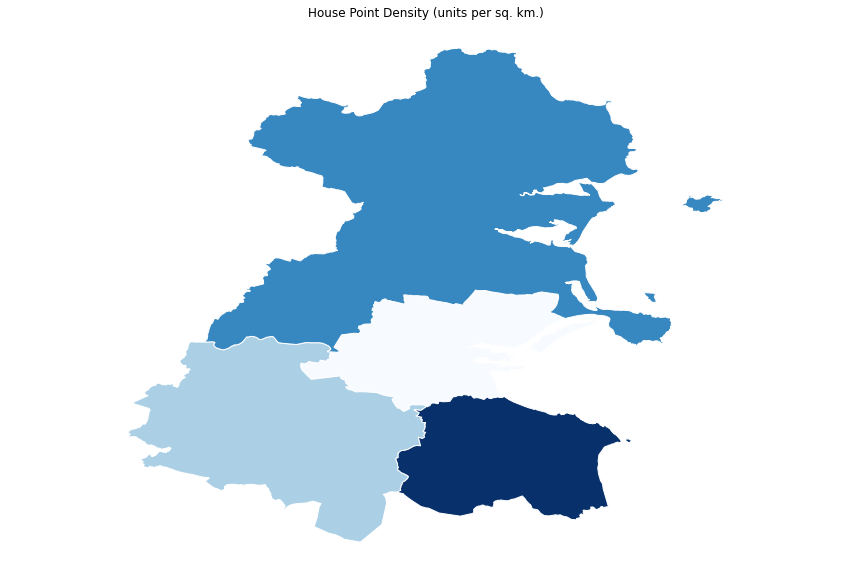

In [47]:
f, ax = plt.subplots(1, figsize=(15, 10)) #Subplots allows you to draw multiple plots in one figure
dub_nb.plot(ax=ax,cmap='Blues', edgecolor='white')
ax.set_axis_off() #Remove axes from plot 
ax.set_title('House Point Density (units per sq. km.)') #Plot title text
plt.axis('equal') #Set x and y axes to be equal size
plt.show()

In [38]:
dub_map2['geometry']

Series([], Name: geometry, dtype: geometry)